<a href="https://colab.research.google.com/github/nanditavenkatesh/Fine-Tuning-Bert-Classifier-for-Sentiment-Analysis/blob/main/BERT_Fine_Tuning_for_Sentiment_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## References:

1. https://huggingface.co/transformers/v3.0.2/model_doc/auto.html#automodelforsequenceclassification

2. https://stackoverflow.com/questions/65097733/creating-a-train-and-a-test-dataloader

3. https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html

4. https://pytorch.org/docs/stable/generated/torch.argmax.html

5. https://huggingface.co/docs/transformers/en/model_doc/distilbert

6. https://www.kdnuggets.com/2023/03/introduction-getitem-magic-method-python.html

# 🤖 BERT Fine-Tuning for Sentiment Classification

In this project we will revisit the sentiment classification task that we did in Text Classification Project. However, instead of using Naive Bayes and logistic regression, we will build a neural network classifier by fine-tuning a pretrained language model.


## Imports and package installation

In [ ]:
!pip install transformers torch datasets tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 3.3 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import torch, codecs, random
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
import datasets
from datasets import load_metric
from google.colab import output
import matplotlib.pyplot as plt
import numpy as np
from typing import List, Dict, Any
from transformers import PreTrainedTokenizer
from torch.optim import Optimizer
from sklearn.model_selection import train_test_split

output.enable_custom_widget_manager()

# Uncomment if using Drive to upload the dataset
# from google.colab import drive
# drive.mount("/content/drive", force_remount=True)

If the following fails, your current Colab runtime doesn't have a GPU. To fix this, simply select 'Runtime' -> 'Change runtime type', then select 'GPU' under 'Hardware accelerator' and then press save.

In [ ]:
assert torch.cuda.is_available()

## Part 1 - Dataset Preparation


### 1. Reading in the data

The dataset contains a total of 5,000 tweets labeled with their sentiment. The first 3,000 will be used in training. The next 1,000 will be used as a validation set, and the final 1,000 will be used for testing. The `'text'` column contains a raw Tweet, and the `'sentiment'` column contains the label (`'negative'`, `'neutral'`, or `'positive'`).



In [ ]:
!wget "https://raw.githubusercontent.com/nanditavenkatesh/CSCI_6515_NLU/main/HW1/Tweets_5K.csv" "Tweets_5K.csv"

--2024-04-16 00:44:31--  https://raw.githubusercontent.com/nanditavenkatesh/CSCI_6515_NLU/main/HW1/Tweets_5K.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 455926 (445K) [text/plain]
Saving to: ‘Tweets_5K.csv’

Tweets_5K.csv       100%[===================>] 445.24K  --.-KB/s    in 0.03s   

2024-04-16 00:44:32 (15.9 MB/s) - ‘Tweets_5K.csv’ saved [455926/455926]

--2024-04-16 00:44:32--  http://tweets_5k.csv/
Resolving tweets_5k.csv (tweets_5k.csv)... failed: Name or service not known.
wget: unable to resolve host address ‘tweets_5k.csv’
FINISHED --2024-04-16 00:44:32--
Total wall clock time: 0.3s
Downloaded: 1 files, 445K in 0.03s (15.9 MB/s)


In [ ]:
import pandas as pd

# Change this folder if you've placed the .csv elsewhere in your drive.
FOLDER = "/content"  # Extend this string to point to the directory with your copy of Tweets_5K.csv
FILEPATH = f"{FOLDER}/Tweets_5K.csv"

dataset = pd.read_csv(FILEPATH, header=0, sep=',')

# adding a column called labels with -1 for negative sentiment, 0 for neutral sentiment and 1 for positive sentiment
dataset.insert(3, "labels", np.where(dataset["sentiment"] == "positive",0,np.where(dataset["sentiment"] == "negative",1,2)))


# X should be raw tweet text, y should be integer labels from the sentiment column ('negative': 0, 'neutral': 1, 'positive': 2)
# X: List<String>
# y: List<int> (can be list-like)
X = dataset['text'].to_list()
y = dataset["labels"].to_list()

# split X and y into a train/validation/test set, use fixed-indices (3000/1000/1000)
trainset, trainlabs = X[:3000], y[:3000]
valset, vallabs = X[3000:4000], y[3000:4000]
testset, testlabs = X[4000:], y[4000:]

### 2. Preparing the dataset


 To set up our data and to read it into our models, we will use Pytorch's `Dataset` and `DataLoader`,

  Here, we will define a child class to the Pytorch `Dataset` class, such that we can customize it for our specific dataset, and also configure the tokenizer (which we'll initialize in a moment), which will get our data set up in the format required for the models. A custom `Dataset` class requires three functions:  `__init__`, `__len__`, and `__getitem__`.  The `__getitem__` function is what will be used to fetch all training examples by the eventual dataloader. `__getitem__` will tokenize the input tweets in the BERT fashion ([CLS] and [SEP] tokens need to be inserted as discussed in lecture, etc.)

In [ ]:
class TweetDataset(torch.utils.data.Dataset):
  """
  A PyTorch Dataset for our tweets that can be iterated through using __getitem__
  """
  def __init__(self, tweets : List[str], sentiments : List[int], tokenizer : PreTrainedTokenizer) -> None:
    """
    Initializes the TweetDataset from a list of tweets, their corresponding sentiments, and a tokenizer.

    Attributes
    ----------
    tweets : List[str]
      A list of tweets, where each tweet is a string
    sentiments: List[int]
      A list of sentiments represented as integers ('negative': 0, 'neutral': 1, 'positive': 2)
    tokenizer : PreTrainedTokenizer
      Any PreTrainedTokenizer from HuggingFace can be used to encode the string inputs for a model
    """
    self.tweets = tweets
    self.sentiments = sentiments
    self.tokenizer = tokenizer
    self.max_len = tokenizer.model_max_length

  def __len__(self) -> int:
    """
    Returns the number of tweets in the dataset.
    """
    return len(self.tweets)

  def __getitem__(self, index : int) -> Dict[str, Any]:
    """
    Retrieve a preprocessed data item from the dataset at the specified index.
    This is called when iterating through a TweetDataset

    Parameters:
    ----------
    index : int
        The index of the data item to retrieve.

    Returns:
    -------
    Dict[str, Any]
        A dictionary containing the preprocessed data for the given index.
        The dictionary includes the following keys:
        - 'input_ids': Encoded input IDs for the tweet.
        - 'attention_mask': Attention mask for the tweet.
        - 'labels': Sentiment label as a PyTorch tensor.
    """
    tweet = str(self.tweets[index])
    sentiments = self.sentiments[index]

    encoded_tweet = self.tokenizer.encode_plus(
      tweet,
      add_special_tokens      = True,
      max_length              = self.max_len,
      return_token_type_ids   = False,
      return_attention_mask   = True,
      return_tensors          = "pt",
      padding                 = "max_length",
      truncation              = True
    )

    return {
      'input_ids': encoded_tweet['input_ids'][0],
      'attention_mask': encoded_tweet['attention_mask'][0],
      'labels': torch.tensor(sentiments, dtype=torch.long)
    }

### 3. Tokenizer and dataloader:


Now that we have the `TweetDataset` class, we must construct the appropriate instances for our training, validation, and testing sets. Afterwhich, they must be used to construct PyTorch `DataLoader` instances (refer to PyTorch [documentation](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html)).

At this point, batch sizes will have to be specified. The batch size dictates how many training instances are seen before the model's parameters are updated in gradient descent. For example, with a batch size of 32, the model will process 32 input sentences, before updating weights/parameters. Choosing the batch size may require some experimentation. The larger the batch size, the faster the models will train (because we aren't calculating gradients and updating as often). However, larger batch sizes will also use more VMEM (Video Memory, like RAM, but on a GPU).

Finally, we'll use the distilbert-base-uncased tokenizer from Hugging Face to preprocess our tweets. This matches the model we will use down the line, and ensures our input is in the right format.

In [ ]:
from transformers import AutoTokenizer
from torch.utils.data import DataLoader

# use this for the tokenizer argument of the TweetDataset
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

# define the following TweetDataset objects... be careful to split the data as previously specified
train_dataset = TweetDataset(trainset, trainlabs, tokenizer)
validation_dataset = TweetDataset(valset, vallabs, tokenizer)
test_dataset = TweetDataset(testset, testlabs, tokenizer)

# now construct DataLoader objects from the TweetDataset objects
# remember that the TweetDataset class is a child class of torch.utils.data.Dataset
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

## Part 2: Untrained Model (Baseline)

### 1. Loading untrained model:

In [ ]:
from transformers import AutoConfig, AutoModelForSequenceClassification

# getting the distilbert-base-uncased config...
config = AutoConfig.from_pretrained("distilbert-base-uncased", num_labels=3)
# ...from which we can use AutoModelForSequenceClassification to instantiate
# an UNTRAINED version of the above model, read Hugging Face documentation
# to figure out how to do so!
untrained_model = AutoModelForSequenceClassification.from_config(config)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

### 2. Write function to evaluate model predictions

We need to define an evaluation function, such that we can measure a model's performance on a dataset. Here, we will be looking at accuracy.

For evaluation, there are a couple of steps that must be taken. For each batch in the evaluation set:
1. Apply the model on the batch (feedforward pass through the model)
2. Obtain the predictions from the model output
3. Update the metrics and progress bar


**A note on logits**: DistilBERT's classifier outputs "logits". Logits are unnormalized predictions of a model (i.e., this is the input to the softmax function we've discussed in class). In this case, we have three classes: negative, neutral, or positive. One can assign a single output at the end of a model to each of these classes. For the purpose of this project, we will define the model's prediction to be the class with the maximum logit value (i.e., take the argmax across the outputs). That is, the argmax of the logits is our prediction, which can be compared to the label. This may be useful when tracking metrics. Note: Softmax takes the logits as input and acts as a normalizing function, which outputs a probability distribution over the outputs. But, the argmax of the logits will be the same as the argmax of the softmax output, so no need to use softmax here.

**A note on PyTorch devices**

In PyTorch, tensor operations can be performed on devices, usually CPUs and GPUs. Tensors can be set to certain devices to optimize operations through parallelization. The operation to set a tensor to a device can be seen [here](https://pytorch.org/docs/stable/generated/torch.Tensor.to.html). Note that the returned tensor is now a copy if the device is changed. **Hint**: Setting a tensor to the correct device is necessary when using them for a model on the GPU!

In the code below, the model's parameters are loaded onto the device we are using. This gives us a way to use the GPU to run models by putting all of its parameters and computations on it!



In [ ]:
# For any parameter named 'device', pass the following variable:
device = torch.device("cuda")

# Loading the model onto the device
untrained_model.to(device)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [ ]:
def update_metrics(metrics: List[datasets.Metric], predictions: torch.Tensor, labels: torch.Tensor) -> None:
  """
  Update a list of metrics with new predictions and labels

  Parameters:
  -----------
  metrics : List[Metric]
      List of metrics.
  predictions : torch.Tensor
      Tensor of predictions of shape (batch_size, ...)
  labels : torch.Tensor
      Tensor of labels of shape (batch_size, ...)

  Returns:
  --------
  None
  """
  # Nothing TODO here! This updates metrics based on a batch of predictions
  # and a batch of labels.
  for metric in metrics:
    metric.add_batch(predictions=predictions, references=labels)

def evaluate(model: torch.nn.Module, test_dataloader: torch.utils.data.DataLoader,
             device: torch.device, metric_strs: List[str]) -> Dict[str, float]:
  """
  Evaluate a PyTorch Model

  Parameters:
  -----------
  model : torch.nn.Module
      The model to be evaluated.
  test_dataloader : torch.utils.data.DataLoader
      DataLoader containing testing examples.
  device : torch.device
      The device that the evaluation will be performed on.
  metric_strs : List[str]
      The names of Hugging Face metrics to use.

  Returns:
  --------
  Dict[str, float]
      Dictionary of metric names mapped to their values.
  """
  # load metrics
  metrics = [load_metric(x) for x in metric_strs] # could add more here!
  model.eval()

  # we like progress bars :)
  progress_bar = tqdm(range(len(test_dataloader)))
  # HINT: progress_bar.update(1) should be used to show progress after an iteration

  # TODO: Fill in the evaluate function by applying the model with the dataloader
  for batch in test_dataloader:
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['labels'].to(device)

    # passing inputs
    computed_values = model(input_ids, attention_mask = attention_mask)
    logits = computed_values.logits
    # computing argmax
    y_pred = torch.argmax(logits, dim = 1)

  # HINT: Use .detach() before passing the predictions into update_metrics to prevent memory issues
  # and to send the model inputs to the device the model is on
    update_metrics(metrics, y_pred.detach(), labels)

    # updating progress bar
    progress_bar.update(1)

  # compute and return metrics (nothing TODO here)
  computed = {}
  for m in metrics:
    computed = {**computed, **m.compute()}

  return computed

### 3. Baseline performance:

Now that we have an untrained model, our dataset, and an evaluation function, we can evaluate the to find our baseline accuracies!

In [ ]:
from scipy.stats import describe
from math import sqrt

def make_plots(perfs: List[float], names: List[str]) -> None:
  """
  Create bar plots for performance metrics.

  Parameters:
  -----------
  perfs : List[float]
      List of performance values (e.g., accuracies).
  names : List[str]
      List of names for the corresponding performance metrics.
  """
  # Nothing TODO here
  for perf, name in zip(perfs, names):
    print(f"{name} accuracy: {perf}")
  plt.bar(np.arange(len(perfs)), perfs)
  plt.xticks(np.arange(len(names)), names)
  plt.show()

  0%|          | 0/63 [00:00<?, ?it/s]

Baseline accuracy: 0.265


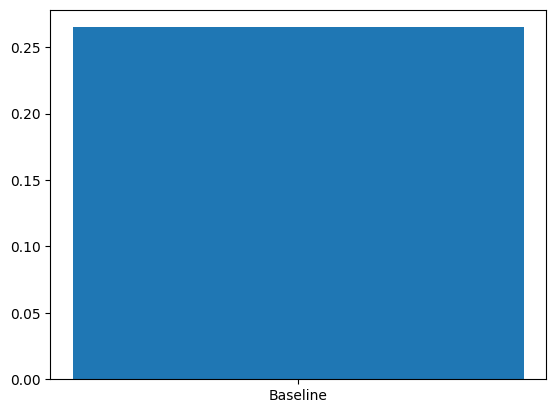

In [ ]:
metrics = ['accuracy']
# TODO: evaluate on the test dataset
baseline_result = evaluate(model = untrained_model, test_dataloader = test_dataloader, device = device, metric_strs = metrics)['accuracy']

# now, plot! Do not modify the following:
results = [baseline_result]
names = ['Baseline']
make_plots(results, names)

In [ ]:
# deleting model
del untrained_model

# empty cache
torch.cuda.empty_cache()

## Part 3 - Model trained for sentiment analysis from scatch




In this part of the project, we will take our completely untrained model and train it to perform sentiment analysis. That is, wee will update the weights so as to get as good performance as possible at predicting sentiment.

### 1. Write a function to train our model

The training loop will follow similar steps to the evaluation loop:
For each batch in each epoch (an epoch is one pass through all of the training data), you will:
1. Apply the model on the batch inputs (feedforward pass through the model)
2. Obtain the predictions, as well as the labels
3. Compare the predictions with the labels and calculate the loss
4. Backpropagate the loss and obtain gradients for all parameters
5. Update the optimizer and learning rate
6. Record the desired metrics based on the outputs and labels
In addition to this, we'd like to keep track of some metrics during each epoch, and at the end of an epoch we want to run an evaluation on the validation set  Specifically, we want to know the training accuracy (accuracy measured against the training set) and validation accuracy - they can be reported through `print` statements.




In [ ]:
# initalizing model
# getting the distilbert-base-uncased config...
config = AutoConfig.from_pretrained("distilbert-base-uncased", num_labels=3)
# ...from which we can use AutoModelForSequenceClassification to instantiate
# an UNTRAINED version of the above model, read Hugging Face documentation
# to figure out how to do so!
manually_trained_model = AutoModelForSequenceClassification.from_config(config)

In [ ]:
# Loading the model onto the device
manually_trained_model.to(device)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [ ]:
def train(model: torch.nn.Module, optimizer: Optimizer, num_epochs: int,
          train_dataloader: DataLoader, validation_dataloader: DataLoader,
          lr_scheduler: Any, device: torch.device) -> None:
  """
  Trains a model by performing a forward pass and backpropating on batches to optimize loss.

  Parameters:
  -----------
  model : torch.nn.Module
      The model to be trained.
  optimizer : torch.optim.Optimizer
      The training optimizer.
  num_epochs : int
      Number of epochs to train for.
  train_dataloader : DataLoader
      DataLoader containing training examples.
  validation_dataloader : DataLoader
      DataLoader containing validation examples.
  lr_scheduler : Any
      Learning rate scheduler.
  device : torch.device
      The device that the training will be performed on.

  Returns:
  --------
  None
  """

  # Define your loss function; Use CrossEntropyLoss
  loss_function = torch.nn.functional.cross_entropy

  for epoch in range(num_epochs):
    # put the model in training mode (important that this is done each epoch,
    # since we put the model into eval mode during validation)
    model.train()

    # load metrics
    metrics = [load_metric(x) for x in ["accuracy"]] # could add more here!

    print(f"Epoch {epoch + 1} training:")
    progress_bar = tqdm(range(len(train_dataloader)))

    # TODO: Fill in the rest of the train function by applying the model with the dataloader
    for batch in train_dataloader:
      input_ids = batch['input_ids'].to(device)
      attention_mask = batch['attention_mask'].to(device)
      labels = batch['labels'].to(device)

      optimizer.zero_grad()
      # passing inputs
      computed_values = model(input_ids, attention_mask = attention_mask)
      logits = computed_values.logits
      # computing argmax
      y_pred = torch.argmax(logits, dim = 1)
      train_loss = loss_function(logits,labels)
      train_loss.backward()
      optimizer.step()
      lr_scheduler.step()
      update_metrics(metrics, y_pred.detach(), labels.detach())
          # updating progress bar
      progress_bar.update(1)
    # HINT: Remember to use .detach() before passing model predictions to update_metrics function,
    # and to send the model inputs .to() the device that the model is on

    # print the epoch's average metrics
    print(f"Epoch {epoch+1} average training metrics: accuracy={metrics[0].compute()['accuracy']}")

    # normally, validation would be more useful when training for many epochs
    print("Running validation:")
    # TODO: evaluate model on validation dataset
    val_metrics = evaluate(model = model, test_dataloader = validation_dataloader, device = device, metric_strs = ["accuracy"])
    print(f"Epoch {epoch+1} validation: accuracy={val_metrics['accuracy']}")


### 2. Training the untrained model:

Train the model for **2 epochs**!


First, we need to set up our optimizer, learning rate scheduler, and determine the number of epochs to train for. These are all parameters to the `train` function.

In [ ]:
from transformers import get_scheduler

num_epochs = 2

# TODO: use the AdamW optimizer. Use torch.optim.AdamW.
# instantiate it on the untrained model parameters with a learning rate of 5e-5
optimizer = torch.optim.AdamW(manually_trained_model.parameters(), lr = 5e-5)

# now, we set up the learning rate scheduler
lr_scheduler = get_scheduler(
  "linear",
  optimizer=optimizer,
  num_warmup_steps=50,
  num_training_steps=len(train_dataloader) * num_epochs
)

In [ ]:
torch.cuda.empty_cache()

# TODO: now call your training loop!
train(manually_trained_model, optimizer, num_epochs, train_dataloader, validation_dataloader, lr_scheduler, device)

Epoch 1 training:


  0%|          | 0/188 [00:00<?, ?it/s]

Epoch 1 average training metrics: accuracy=0.4056666666666667
Running validation:


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch 1 validation: accuracy=0.525
Epoch 2 training:


  0%|          | 0/188 [00:00<?, ?it/s]

Epoch 2 average training metrics: accuracy=0.5976666666666667
Running validation:


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch 2 validation: accuracy=0.585


Hypothetically, the untrained model is now slightly trained.

### 3. Evaluate the trained model:

Call the evaluation loop on the model we just trained! View the bar graph to compare it to the baseline.

  0%|          | 0/63 [00:00<?, ?it/s]

Baseline accuracy: 0.265
Manually Trained accuracy: 0.579


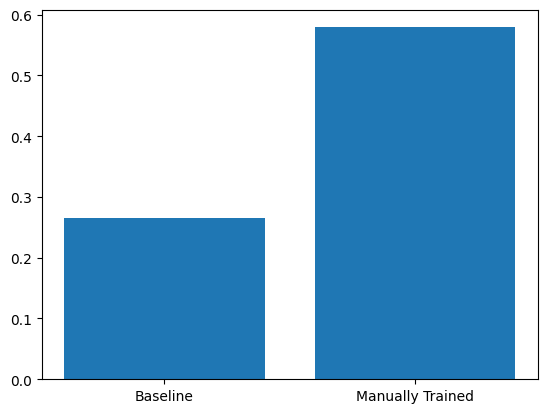

In [ ]:
metrics = ['accuracy']

# TODO: Evaluate on test dataset!
trained_result = evaluate(model = manually_trained_model, test_dataloader = test_dataloader, device = device, metric_strs = metrics)['accuracy']

# now, plot! Do not modify the following:
results = baseline_result, trained_result
names = ['Baseline', 'Manually Trained']
make_plots(results, names)

As you can see, this model achieves an accuracy of around 55% after the first two epochs. To achieve better performance when training DistilBERT from scratch for this purpose, we'd need a lot more data and a lot more time (and/or compute). Fortunately, there is a better way!

In [ ]:
# deleting model
del manually_trained_model

# empty cache
torch.cuda.empty_cache()

## Part 4 - Finetuning a pre-trained model

Since manually training the model for sentiment analysis didn't work very well, let's fine-tune a pre-trained model.

### 1. Load pre-trained model:

This time, we'll make use of a pre-trained version of DistilBERT - everything's the same as before, but the model has actually already been trained for a masked language modeling task.

In [ ]:
from transformers import DistilBertForSequenceClassification

# TODO: load the distilbert-base-uncased pre-trained model, use DistilBertForSequenceClassification
# from Hugging Face (transformers), read their documentation to do this.
# WARNING: This dataset has three classes! The default for this model is two!
pretrained_model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased",  num_labels = 3, problem_type = "multi_label_classification")

# Ignore the warnings printed below.

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Let's give it a test run...
To motivate, the pre-trained model isn't particularly good at this specific task out-of-the box, to see this, evaluate it on the test set just the way it is.

  0%|          | 0/63 [00:00<?, ?it/s]

Baseline accuracy: 0.265
Manually trained accuracy: 0.579
Pre-trained accuracy: 0.273


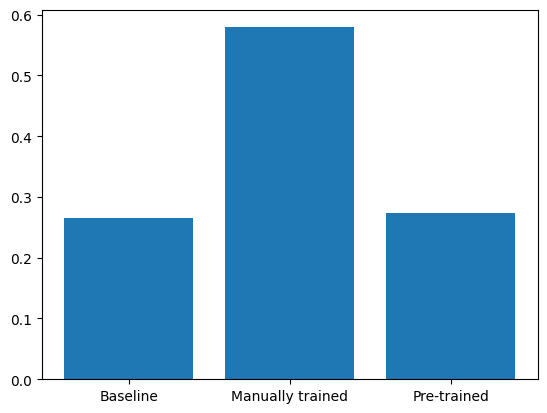

In [ ]:
# We have to move it to the device before doing anything with it!
pretrained_model.to(device)

# TODO: call evaluate on the pre-trained model!
pretrained_result = evaluate(model = pretrained_model, test_dataloader = test_dataloader, device = device, metric_strs = metrics)['accuracy']

# now, plot! Do not modify the following:
results = [baseline_result, trained_result, pretrained_result]
names = ['Baseline', 'Manually trained', 'Pre-trained']
make_plots(results, names)

As we can see, without any fine-tuning, the pre-trained model performs rather badly.

### 2. Fine-tuning pre-trained model:

Rather than train the model from scratch, we'll now fine-tune the pre-trained model! That is, we will take the model that was trained to predict masked words,
and now train it on our sentiment analysis task.
We'll fine-tune by simply running the `train` function on our pre-trained model with the training data! Fine-tune it for **2 epochs**.

In [ ]:
num_epochs = 2

# TODO: use the same kind of optimizer as before, but with the pretrained model's parameters
optimizer = torch.optim.AdamW(pretrained_model.parameters(), lr = 5e-5)

# this hasn't changed
lr_scheduler = get_scheduler(
  "linear",
  optimizer=optimizer,
  num_warmup_steps=50,
  num_training_steps=len(train_dataloader) * num_epochs
)

In [ ]:
torch.cuda.empty_cache()
pretrained_model.to(device)

# TODO: train!
train(pretrained_model, optimizer, num_epochs, train_dataloader, validation_dataloader, lr_scheduler, device)

Epoch 1 training:


  0%|          | 0/188 [00:00<?, ?it/s]

Epoch 1 average training metrics: accuracy=0.6183333333333333
Running validation:


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch 1 validation: accuracy=0.74
Epoch 2 training:


  0%|          | 0/188 [00:00<?, ?it/s]

Epoch 2 average training metrics: accuracy=0.8263333333333334
Running validation:


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch 2 validation: accuracy=0.76


### 3. Evaluating the fine-tuned model:

  0%|          | 0/63 [00:00<?, ?it/s]

Baseline accuracy: 0.265
Manually trained accuracy: 0.579
Pre-trained accuracy: 0.273
Fine-tuned accuracy: 0.756


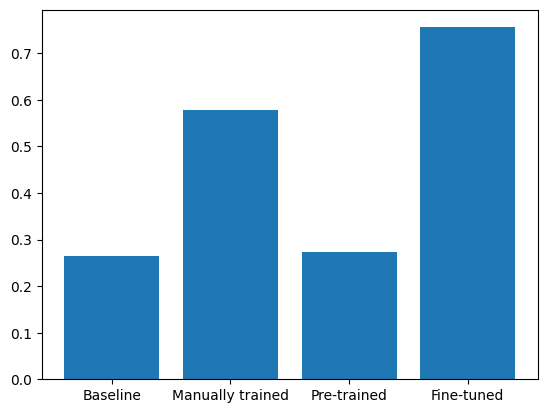

In [ ]:
# TODO: Evaluate the fine-tuned model on the test dataset
finetuned_result = evaluate(model = pretrained_model, test_dataloader = test_dataloader, device = device, metric_strs = metrics)['accuracy']

# now, plot! Do not modify the following:
results = [baseline_result, trained_result, pretrained_result, finetuned_result]
names = ['Baseline', 'Manually trained', 'Pre-trained', 'Fine-tuned']
make_plots(results, names)

Wow! With just two epochs of training, and only 3k training examples, we can achieve ~75% accuracy (this should be attainable)! As we can see, the pre-trained model has a very noticeable advantage over the completely untrained one. Training for an additional epoch renders a slight improvement, afterwhich the fine-tuning begins to overfit on our training set, which can be judged by comparing the average epoch training accuracies and validation accuracies.


## Part 5

1. Take a look at Dataset and the BERT tokenizer (as well as their documentation). Print the output of `__getitem__` for one tweet. What does `__getitem__` return? what the zeros mean?


In [ ]:
test_dataset.__getitem__(1)

{'input_ids': tensor([  101,  1035,  2572,  1035,  8529, 17298,  2102,  2821,  2053,   999,
          1045,  1036,  1049,  2200,  3374,  2000,  2963,   102,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,   

**Ans:** __getitem__ return a dictionary containing the preprocessed data for the given index. The three componets are 'input_ids', 'attention_mask' ,'labels'. The 'input_ids' represent the word embedding values for each word in the tweet, the zeros are used for padding to have the same length for all tensors, 'attention_mask' is used to denote which values are the actual words and which values are padding values. The 1's show denote that they are actual words and 0's denote that they are padding values. 'labels' dentotes the sentiment of the tweet.

2. Reporting the accuracy observed for each. Evaluation on why each model performs the way it does.

**Ans:**

Untrained Model: The untrained model was not trained at all over the dataset, so it expectedly did not perform well. It resulted in accuracy of 0.265.

Manually Trained Model: The manually trained model was trained only for two epochs over the training data. It resulted in accuracy of 0.579. This shows that the model was able to learn information after training and was not a random result.

Pre-Trained Model: The pre-trained model was not tained on our data set so it was did not do a good job of predicting sentiment. It resulted in accuracy of 0.273. I expected better results from the pre-trained model and I was not able to deduce why the accuracy was just as low as un trained model.

Fine-Tuned Model: The fine tuned model performed the best giving the highest accuracy of 0.756. Even with training of just two epochs it was able to adjust weights on the pre-training and it could learn a lot better faster.


3. Listing at least two factors that a person may wish to consider and their implications for which method(s) would be best.

**Ans:** I think one of the main factors that is to be considered is computational power. If enough computation power and resources are available we could spend enough time to train a model to perform very well for a specific task. If this is not the case then it would do a lot better to perform fine tuning and obtain comparable performance.

The other factor would be time. I have come to understand that LLM's like the ones trained by openAI and google take months to train, if the application has no time constraints then we can go ahead and try manually trained models, where as if there is a strict constraint of time it would be much better to fine-tune on a pre-trained model. This would be much faster to train compared to manually training it.

